<a href="https://colab.research.google.com/github/WinsalotNot/LSTM_with_XGBoost_AI_Model/blob/main/Final_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub

# **LIBRARY IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical

import xgboost as xgb

# **DATA PREPROCESSING**

In [2]:
path = kagglehub.dataset_download("hasibullahaman/traffic-prediction-dataset")
print("Path to dataset files:", path)

# Step 2: Load traffic.csv file and clean up dataset
df = pd.read_csv(f"{path}/Traffic.csv")

# Map categorical traffic labels to numeric classes
traffic_mapping = {'heavy': 0, 'high': 1, 'normal': 2, 'low': 3}
df['TrafficClass'] = df['Traffic Situation'].map(traffic_mapping)

# Combine Date and Time into a proper datetime [Date, Hour, Minute, Seconds, AM/PM]
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], format='%d %I:%M:%S %p')
df_sorted = df.sort_values(by='DateTime', ascending=True)
print(df_sorted)

day_dummies = pd.get_dummies(df_sorted['Day of the week'], prefix='day')
df_sorted = pd.concat([df_sorted, day_dummies], axis=1)

# Step 1: Split data into training, validation, and prediction (test)
train_size = int(len(df_sorted) * 0.9)
train_val_df = df_sorted.iloc[:train_size] # 90% for training and validation combined
test_df = df_sorted.iloc[train_size:]  # 10% for prediction (test)

train_size = int(len(train_val_df) * 0.8)
train_df = train_val_df[:train_size]  # 80% of the train_val data for training
val_df = train_val_df[train_size:]  # 20% of the train_val data for validation

# Normalize vehicle count features for LSTM (LSTM is sensitive to input scale)
vehicle_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
scaler = MinMaxScaler() # (x-xmin)/(xmax-xmin) = [0, 1]
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[vehicle_cols] = scaler.fit_transform(train_df[vehicle_cols]) # Use current scaler as base scaler in scaler machine
val_df_scaled[vehicle_cols] = scaler.transform(val_df[vehicle_cols])  # Use the same scaler for validation data
test_df_scaled[vehicle_cols] = scaler.transform(test_df[vehicle_cols])  # Use the same scaler for test data

training_data = train_df_scaled[vehicle_cols].values
validation_data = val_df_scaled[vehicle_cols].values
testing_data = test_df_scaled[vehicle_cols].values


100%|██████████| 83.1k/83.1k [00:00<00:00, 6.69MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hasibullahaman/traffic-prediction-dataset/versions/2
             Time  Date Day of the week  CarCount  BikeCount  BusCount  \
2112  12:00:00 AM     1       Wednesday        14          0         0   
2113  12:15:00 AM     1       Wednesday        17          5         0   
2114  12:30:00 AM     1       Wednesday        19          1         1   
2115  12:45:00 AM     1       Wednesday        15          5         1   
2116   1:00:00 AM     1       Wednesday        13          2         1   
...           ...   ...             ...       ...        ...       ...   
2107  10:45:00 PM    31         Tuesday        14          2         0   
2108  11:00:00 PM    31         Tuesday        12          2         1   
2109  11:15:00 PM    31         Tuesday        18          0         1   
2110  11:30:00 PM    31         Tuesday        14          5         0   
2111  11:45:00 PM    31         Tuesday        18         

# **LSTM FOR FINDING INDIVIDUAL COUNTS OF VEHICLES**

In [4]:
# Step 2: Create time series data for LSTM for each vehicle type
def create_multivariate_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])  # Create sequence of 'lookback' steps for all features
        y.append(data[i])  # Predict the full feature vector at time 'i'
    return np.array(X), np.array(y)

lookback = 10

X_train_lstm, y_train_lstm = create_multivariate_sequences(training_data, lookback)
X_test_lstm, y_test_lstm = create_multivariate_sequences(testing_data, lookback)
X_val_lstm, y_val_lstm = create_multivariate_sequences(validation_data, lookback)

def create_multivariate_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape)) # First layer used for ensuring fitting is proper, thus high units
    model.add(BatchNormalization()) # Re-centering and re-scaling the activations after LSTM layer
    model.add(Dropout(0.3)) # to reduce overfitting and ensure generalization of ALL data

    model.add(LSTM(units=64)) # Second layer used for "summarizing" first layer sequence output, thus lower units
    model.add(BatchNormalization()) # Re-centering and re-scaling the activations after LSTM layer
    model.add(Dropout(0.3)) # to reduce overfitting and ensure generalization of ALL data

    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size))  # Output = 4 (Car, Bike, Bus, Truck)
    model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4), loss='huber', metrics=['mae'])

    return model

model = create_multivariate_lstm_model((lookback, 4), 4)

# Add callbacks for training stability and improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_scaled = model.predict(X_test_lstm)

# Reshape to inverse scale
y_pred_full = scaler.inverse_transform(y_pred_scaled)
y_test_full = scaler.inverse_transform(y_test_lstm)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.2195 - mae: 0.5278 - val_loss: 0.0602 - val_mae: 0.2551 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0725 - mae: 0.3029 - val_loss: 0.0475 - val_mae: 0.2239 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0460 - mae: 0.2408 - val_loss: 0.0371 - val_mae: 0.2016 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0373 - mae: 0.2156 - val_loss: 0.0354 - val_mae: 0.2010 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0302 - mae: 0.1938 - val_loss: 0.0255 - val_mae: 0.1714 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0264 - mae: 0.1801 - val_loss: 0.0216 - val_mae: 0.1580 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0236 - mae: 0.1701 - val_loss: 0.0201 - val_mae: 0.1582 - learning_rate: 0.0010
Epoch 

# **DOWNSAMPLE TRAINING SET FOR XGBOOST AND ANN COMPARISON**

In [5]:
# Group by TrafficClass and get minimum count
min_count = train_val_df['TrafficClass'].value_counts().min()

# Sort by DateTime descending (latest first)
train_val_df_sorted_latest = train_val_df.sort_values(by='DateTime', ascending=False)

# Downsample each class to min_count using the most recent entries
balanced_train_df = (
    train_val_df_sorted_latest
    .groupby('TrafficClass', group_keys=False)
    .apply(lambda x: x.head(min_count))
    .reset_index(drop=True)
)

print("Balanced train_df sample count per class:")
print(balanced_train_df['TrafficClass'].value_counts())
print(train_val_df['TrafficClass'].value_counts())


Balanced train_df sample count per class:
TrafficClass
0    284
1    284
2    284
3    284
Name: count, dtype: int64
TrafficClass
2    1491
0     617
1     286
3     284
Name: count, dtype: int64


<ipython-input-5-4ccec2d1836c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(min_count))


# **XGBOOST TO CLASSIFY THE COUNTS INTO CORRESPONDING TRAFFIC CONDITION**

In [10]:
X_train_balanced = balanced_train_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']]
y_train_balanced = balanced_train_df['TrafficClass']

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    learning_rate=0.1,
    n_estimators=200,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_balanced, y_train_balanced)

xgb_df = pd.DataFrame(y_pred_full, columns=['CarCount', 'BikeCount', 'BusCount', 'TruckCount'])
xgb_df['Total'] = xgb_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].sum(axis=1)

y_pred_xgb = xgb_model.predict(xgb_df)


# **OVERALL ANALYSIS**

CarCount RMSE: 23.25
BikeCount RMSE: 6.89
BusCount RMSE: 7.99
TruckCount RMSE: 7.35
Number of samples per class in training set:
Heavy (Class 0): 284 samples
High (Class 1): 284 samples
Normal (Class 2): 284 samples
Low (Class 3): 284 samples
              Datetime  Actual Predicted
0  1900-01-29 00:00:00  Normal    Normal
1  1900-01-29 00:15:00  Normal    Normal
2  1900-01-29 00:30:00  Normal    Normal
3  1900-01-29 00:45:00  Normal    Normal
4  1900-01-29 01:00:00     Low    Normal
..                 ...     ...       ...
95 1900-01-29 23:45:00     Low    Normal
96 1900-01-30 00:00:00     Low    Normal
97 1900-01-30 00:15:00  Normal    Normal
98 1900-01-30 00:30:00  Normal    Normal
99 1900-01-30 00:45:00  Normal    Normal

[100 rows x 3 columns]


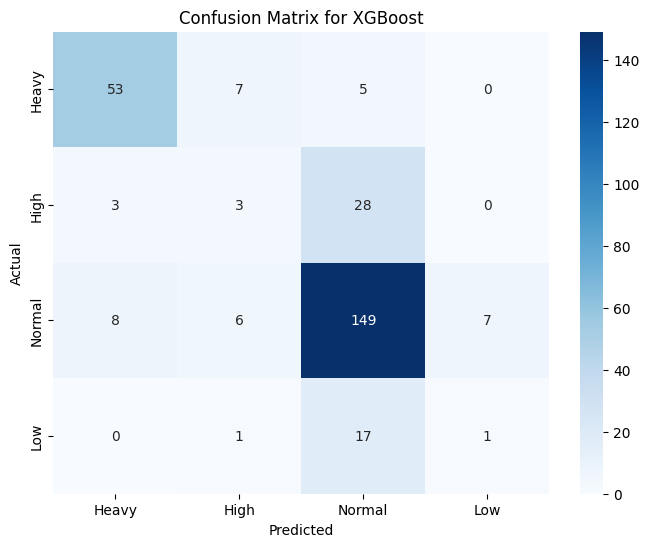

              precision    recall  f1-score   support

     Class 1       0.83      0.82      0.82        65
     Class 2       0.18      0.09      0.12        34
     Class 3       0.75      0.88      0.81       170
     Class 4       0.12      0.05      0.07        19

    accuracy                           0.72       288
   macro avg       0.47      0.46      0.46       288
weighted avg       0.66      0.72      0.68       288

Accuracy: 0.7153


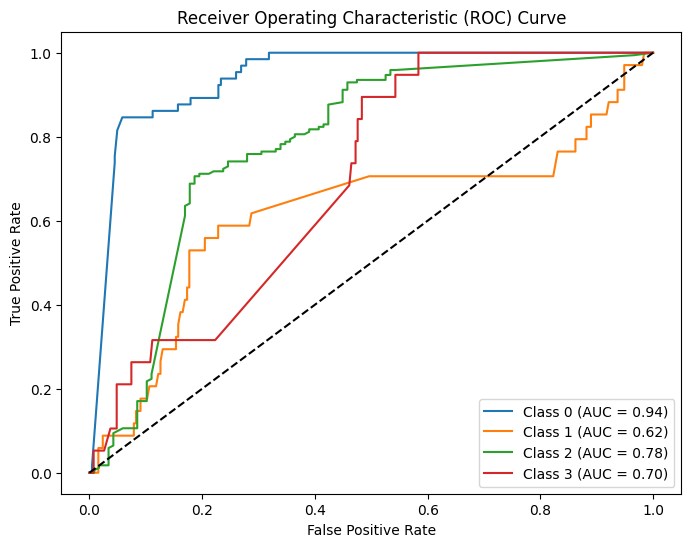

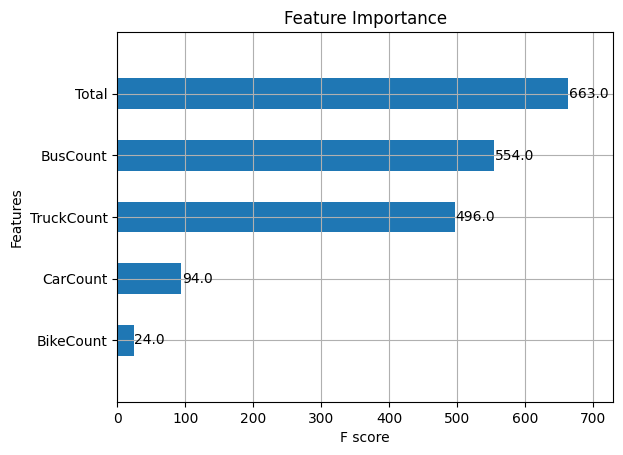

Cross-validation accuracy: 0.9991 ± 0.0018


In [11]:
# RMSE for LSTM
for i, label in enumerate(['CarCount', 'BikeCount', 'BusCount', 'TruckCount']):
    rmse = np.sqrt(mean_squared_error(y_test_full[:, i], y_pred_full[:, i]))
    print(f'{label} RMSE: {rmse:.2f}')

# Data Analysis for XGBOOST

# 'lookback:' to match the input rows from LSTM, which are data from index 'lookback' to the end
y_test_balanced = test_df['TrafficClass'].iloc[lookback:]

label_names = ['Heavy', 'High', 'Normal', 'Low']
inv_map = {v: k.capitalize() for k, v in traffic_mapping.items()}

# Prepare datetime column (make sure to align correctly)
datetime_test = test_df.iloc[lookback:]['DateTime'].reset_index(drop=True)

# Ensure y_test_balanced and y_pred_xgb are Series
y_test_balanced = y_test_balanced.reset_index(drop=True)
y_pred_xgb = pd.Series(y_pred_xgb)

# Decode labels back to string names
result_df = pd.DataFrame({
    'Datetime': datetime_test,
    'Actual': y_test_balanced.map(inv_map),
    'Predicted': y_pred_xgb.map(inv_map)
})

# Count how many samples of each traffic class are used for training
train_class_counts = pd.Series(y_train_balanced).value_counts().sort_index()

print("Number of samples per class in training set:")
for class_id, count in train_class_counts.items():
    print(f"{inv_map[class_id]} (Class {class_id}): {count} samples")

# Print head
print(result_df.head(100))

# Confusion Matrix
cm = confusion_matrix(y_test_balanced, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test_balanced, y_pred_xgb, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4']))

# Accuracy Score
accuracy = accuracy_score(y_test_balanced, y_pred_xgb)
print(f'Accuracy: {accuracy:.4f}')

# ROC Curve (Optional)
y_test_bin = label_binarize(y_test_balanced, classes=[0, 1, 2, 3])
fpr, tpr, roc_auc = {}, {}, {}
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_model.predict_proba(xgb_df)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance', height=0.5)
plt.show()

# Cross-validation Accuracy
cross_val_accuracy = cross_val_score(xgb_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print(f'Cross-validation accuracy: {cross_val_accuracy.mean():.4f} ± {cross_val_accuracy.std():.4f}')

In [16]:
# 1. One-hot encode the labels
y_train_cat = to_categorical(y_train_balanced, num_classes=4)
y_test_cat = to_categorical(test_df['TrafficClass'], num_classes=4)

# Normalize data
# Fit on training data only, then transform both training and test data
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_df_scaled = scaler.transform(test_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].values)

# Ground truth
y_test_truth = test_df['TrafficClass']

# 2. Define the ANN model
model = Sequential([
    Dense(128, input_shape=(5,), activation='relu'), # 5 as there is 4 counts and 1 total
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 classes
])

# 3. Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train_balanced, y_train_cat,
                    validation_split=0.2,
                    epochs=500,
                    batch_size=32,
                    verbose=1)

y_pred_classes = model.predict(X_test_df_scaled)
y_pred_classes = np.argmax(y_pred_classes, axis=1)


Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3724 - loss: 1.3428 - val_accuracy: 0.0000e+00 - val_loss: 1.7546
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6358 - loss: 1.0316 - val_accuracy: 0.0000e+00 - val_loss: 2.0821
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6796 - loss: 0.8495 - val_accuracy: 0.0000e+00 - val_loss: 2.1576
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7209 - loss: 0.7363 - val_accuracy: 0.0000e+00 - val_loss: 2.0584
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7372 - loss: 0.6693 - val_accuracy: 0.0000e+00 - val_loss: 1.9610
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7208 - loss: 0.6647 - val_accuracy: 0.0000e+00 - val_loss: 1.8094
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7708 - loss: 0.5796 - val_accuracy: 0.0000e+00 - val_loss: 1.7156
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - loss: 0.5637 - val_acc


Classification Report:
              precision    recall  f1-score   support

       Heavy       0.22      1.00      0.36        65
        High       0.00      0.00      0.00        35
      Normal       0.00      0.00      0.00       178
         Low       0.00      0.00      0.00        20

    accuracy                           0.22       298
   macro avg       0.05      0.25      0.09       298
weighted avg       0.05      0.22      0.08       298

Accuracy: 0.2181


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


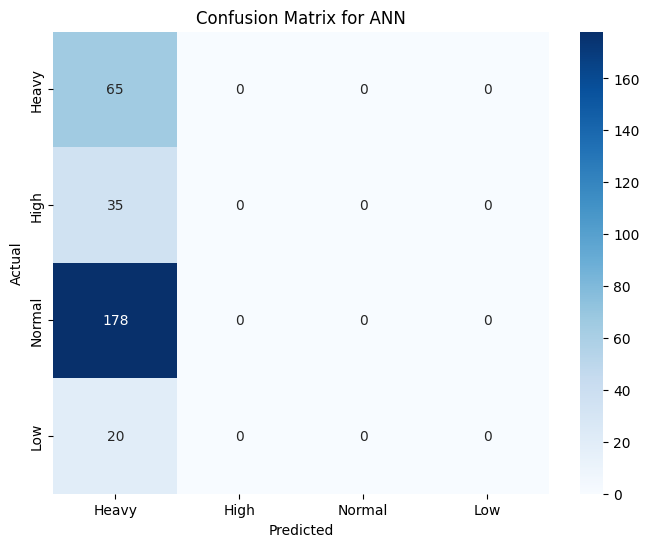

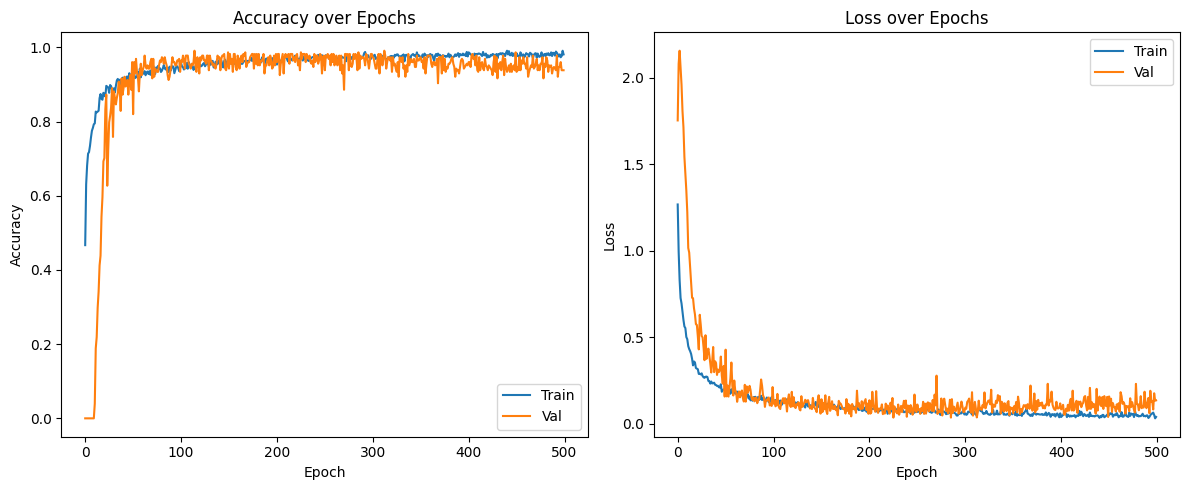

In [17]:
# 6. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test_truth, y_pred_classes, target_names=['Heavy', 'High', 'Normal', 'Low']))

# 8. Accuracy
acc = accuracy_score(y_test_truth, y_pred_classes)
print(f'Accuracy: {acc:.4f}')

# 7. Confusion Matrix
cm = confusion_matrix(y_test_truth, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Heavy', 'High', 'Normal', 'Low'],
            yticklabels=['Heavy', 'High', 'Normal', 'Low'])
plt.title('Confusion Matrix for ANN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

